## Import Libraries

In [15]:
import time
import math
import random

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

from Dataset import load_dataset, SimpleDataset, Preprocessor

from Model.model import MLP
from Model.evaluate import stats, visualize

from Search import ProjectedGradientDescent, RandomSearch

### Set simulation parameters and Cuda

In [3]:
params = {
    'depth': 6,
    'hidden_size': 320,
    'skip_connect': 2,
    'max_time': 60*5, # 5 minutes
    'num_runs': 5,
    'epochs': 100,
    'batch_size': 32,

    'rnd_trials': 10,
    'rnd_time': 5*60, # 5 minutes
    'pgd_trials': 10,  
    'pgd_iter': 1000,  
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using " + str(device))

# Parameters for model evaluation
epochs_candidates = [10, 30, 50, 100, 150]
sizes_candidates = [5, 20, 40, 80, 160, 320, 640]
depths_candidates = [2, 4, 6, 8, 9, 10]
skip_candidates = [0, 2, 3, 4, 5, 6]

Using cuda


## Load the dataset `64` information bytes, 1024  total bits (Rate = 0.5, half the bits are for payload)

In [4]:
data, target = load_dataset('Data/', 'fb1024.txt', 'fer1024.txt')

print(f'Number of samples: {len(data)}, Number of bits: {len(data[0])}')
print(f"Smallest FER: {target.min():E}, largest FER: {target.max():E}")

Number of samples: 15862, Number of bits: 1024
Smallest FER: 5.750000E-05, largest FER: 1.870000E-03


In [5]:
x_train_, x_val_, y_train_, y_val_ = train_test_split(data, target, test_size=0.2)
print(f"# Train samples: {x_train_.shape[0]}, # Validation samples: {x_val_.shape[0]}")

# Train samples: 12689, # Validation samples: 3173


### Feature Preprocessing  

We will analyze how the bit varies within the samples. If the bit remains constant for all samples, we can freely discard them, which will reduce the number of inputs and number of parameters in the neural network. After that, standardize the remaining bits by subtracting mean and dividing by standard deviation.

Furthermore, apply logarithm to the `FER` to simplify the regression task.

In [6]:
# Get the indexes of the bits that vary
indices = torch.where(x_train_.std(dim = 0)>0)[0].numpy()  
print(f"Number of varying indexes: {len(indices)}; {100*len(indices)/len(x_train_[0]):.2f}%")

Number of varying indexes: 112; 10.94%


In [7]:
#Store mean values for each bit (along the samples)
bit_means = torch.mean(x_train_, dim=0, keepdim=True) 

converter = Preprocessor()
converter.fit(x_train_, y_train_, indices, bit_means)
x_train, y_train = converter.transform(x_train_, y_train_)
x_val, y_val = converter.transform(x_val_, y_val_)

print(f"Original train/valid shapes: {x_train_.shape, x_val_.shape}")
print(f"New train/valid shapes: {x_train.shape, x_val.shape}")
print(f"Original FER: {float(y_train_[0]):E}, Converted FER: {float(y_train[0]):E}")

Original train/valid shapes: (torch.Size([12689, 1024]), torch.Size([3173, 1024]))
New train/valid shapes: (torch.Size([12689, 112]), torch.Size([3173, 112]))
Original FER: 2.230000E-04, Converted FER: -8.828996E-01


In [8]:
train_loader = DataLoader(SimpleDataset(x_train, y_train), batch_size=params['batch_size'], shuffle=True) 
val_loader = DataLoader(SimpleDataset(x_val, y_val), batch_size=params['batch_size'])

# Simulations

### 1) Performance vs Epochs

In [17]:
results_epochs = []
for epochs in epochs_candidates:
    print(f"Training for {epochs} epochs")
    model = MLP(input_dim=x_train.shape[1], hidden_size=params['hidden_size'], depth=params['depth'], 
                skip_connect=params['skip_connect']).to(device)
    statistics = stats(model, epochs, train_loader, val_loader, converter, 
                       params['max_time'], params['num_runs'])
    results_epochs.append(statistics)
results_epochs = np.array(results_epochs)

Training for 10 epochs
DONE
Training for 30 epochs
DONE
Training for 50 epochs
DONE
Training for 100 epochs
DONE
Training for 150 epochs
DONE


### 2) Performance vs hidden size

In [12]:
results_sizes = []
for hidden_size in sizes_candidates:
    print(f"Training with hidden size {hidden_size}")
    model = MLP(input_dim=x_train.shape[1], hidden_size=hidden_size, depth=params['depth'], 
                skip_connect=params['skip_connect']).to(device)
    statistics = stats(model, params['epochs'], train_loader, val_loader, converter, 
                       params['max_time'], params['num_runs'])
    results_sizes.append(statistics)
results_sizes = np.array(results_sizes)

Training with hidden size 5
DONE
Training with hidden size 20
DONE
Training with hidden size 40
DONE
Training with hidden size 80
DONE
Training with hidden size 160
DONE
Training with hidden size 320
DONE
Training with hidden size 640
DONE


In [19]:
model = MLP(input_dim=x_train.shape[1], hidden_size=params['hidden_size'], depth=depth, 
                skip_connect=params['skip_connect']).to(device)

In [25]:
model.fit(train_loader, params['epochs'])

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

### 3) Performance vs depth

In [13]:
results_depths = []
for depth in depths_candidates:
    print(f"Training with depth {depth}")
    model = MLP(input_dim=x_train.shape[1], hidden_size=params['hidden_size'], depth=depth, 
                skip_connect=params['skip_connect']).to(device)
    statistics = stats(model, params['epochs'], train_loader, val_loader, converter, 
                       params['max_time'], params['num_runs'])
    results_depths.append(statistics)
results_depths = np.array(results_depths)

Training with depth 2
DONE
Training with depth 4
DONE
Training with depth 6
DONE
Training with depth 8
DONE
Training with depth 9
DONE
Training with depth 10
DONE


### 4) Performance vs skip-connections

In [14]:
results_skips = []
for skip_connect in skip_candidates:
    print(f"Training with skip connections {skip_connect}")
    model = MLP(input_dim=x_train.shape[1], hidden_size=params['hidden_size'], depth=params['depth'], 
                skip_connect=skip_connect).to(device)
    statistics = stats(model, params['epochs'], train_loader, val_loader, converter, 
                       params['max_time'], params['num_runs'])
    results_skips.append(statistics)
results_skips = np.array(results_skips)

Training with skip connections 0
DONE
Training with skip connections 2
DONE
Training with skip connections 3
DONE
Training with skip connections 4
DONE
Training with skip connections 5
DONE
Training with skip connections 6
DONE


## 5) Visualization

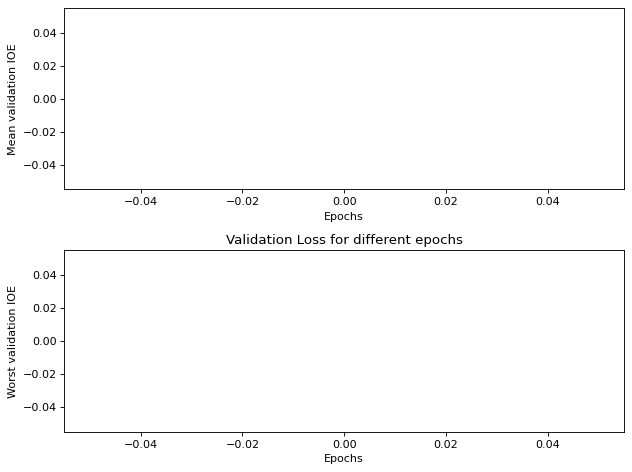

NameError: name 'results_sizes' is not defined

In [11]:
visualize("epochs", epochs_candidates, results_epochs)
visualize("hidden size", sizes_candidates, results_sizes)
visualize("depth", depths_candidates, results_depths)
visualize("skip connections", skip_candidates, results_skips)

# Generating frozen bit set

We will try to find a configuration of bits, which will assure the performance better than the best sample in the dataset (smallest `FER`). For the search, we will first use `Random Search` as a baseline and `Projected Gradient Descent`. The final output will later be evaluated in using `AFF3CT` for the `SNR` of interest and the results will be available in the presentation.

In [ ]:
best_fer_dataset = torch.min(x_train)

### 1) Random Search

In [ ]:
model_rnd = MLP(results_epochs=x_train.shape[1], hidden_size=params['hidden_size'], depth=params['depth'], skip_connect=params['skip_connect']).to(device)
model_rnd.fit(train_loader, params['epochs'])

In [ ]:
for _ in range(params['rnd_trials']):    
    RandomSearch(model_rnd, x_train, converter, params['rnd_time'], best_fer_dataset)

### 2) Projected Gradient Descent

In [ ]:
model_pgd = MLP(results_epochs=x_train.shape[1], hidden_size=params['hidden_size'], depth=params['depth'], skip_connect=params['skip_connect']).to(device)
model_pgd.fit(train_loader, params['epochs'])

In [ ]:
for _ in range(params['pgd_trials']):    
    ProjectedGradientDescent(model_pgd, x_train, converter, params['pgd_iter'], best_fer_dataset)